# Análise de crédito para inadimplentes

O objetivo desse projeto é estudar um conjunto de dados contendo informações sobre uma instituição financeira, onde a estrutura pode ser visto abaixo.

In [1]:
# Remove FutureWarning do seaborn
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Manipulação de dados
import numpy as np
import pandas as pd
# Visualização dos dados
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv('/kaggle/input/credito-data/credito.csv', na_values='na')

In [3]:
df.head(n=5)

,id,default,idade,sexo,dependentes,escolaridade,estado_civil,salario_anual,tipo_cartao,meses_de_relacionamento,qtd_produtos,iteracoes_12m,meses_inativo_12m,limite_credito,valor_transacoes_12m,qtd_transacoes_12m
0,768805383,0,45,M,3,ensino medio,casado,$60K - $80K,blue,39,5,3,1,"12.691,51","1.144,90",42
1,818770008,0,49,F,5,mestrado,solteiro,menos que $40K,blue,44,6,2,1,"8.256,96","1.291,45",33
2,713982108,0,51,M,3,mestrado,casado,$80K - $120K,blue,36,4,0,1,"3.418,56","1.887,72",20
3,769911858,0,40,F,4,ensino medio,NaN,menos que $40K,blue,34,3,1,4,"3.313,03","1.171,56",20
4,709106358,0,40,M,3,sem educacao formal,casado,$60K - $80K,blue,21,5,0,1,"4.716,22","816,08",28


Aqui, nossa variável resposta será a coluna `default`, onde `default = 0` indica clientes adimplentes e `default = 1` indica clientes inadimplentes. 
Busco trazer no final desse projeto possiveis razões pelas quais clientes deixem de pagar suas dívidas a partir de comportamento de seus outros atributos como salário e movimentações financeiras.

## Exploração de dados

Vamos começar conhecendo um pouco nossa estrutura de dados.

In [4]:
qtd_total, _ = df.shape #Verificando quantidade de linhas
qtd_total

10127

In [5]:
qtd_adimplentes, _ = df[df['default'] == 0].shape
qtd_adimplentes

8500

In [6]:
qtd_inadimplentes, _ = df[df['default'] == 1].shape
qtd_inadimplentes

1627

In [7]:
print(f"A proporcão de clientes adimplentes é de {round(100 * qtd_adimplentes / qtd_total, 2)}%")
print(f"A proporcão de clientes inadimplentes é de {round(100 * qtd_inadimplentes / qtd_total, 2)}%")

A proporcão de clientes adimplentes é de 83.93%
A proporcão de clientes inadimplentes é de 16.07%


Agora que conhecemos as proporções da nossa variável de interesse, vamos tentar entender os tipos de dados que estamos lidando. Separando dados categóricos (`object`) e numéricos (`int, float, ...`)

In [8]:
df.dtypes

id                          int64
default                     int64
idade                       int64
sexo                       object
dependentes                 int64
escolaridade               object
estado_civil               object
salario_anual              object
tipo_cartao                object
meses_de_relacionamento     int64
qtd_produtos                int64
iteracoes_12m               int64
meses_inativo_12m           int64
limite_credito             object
valor_transacoes_12m       object
qtd_transacoes_12m          int64
dtype: object

Se observarmos bem, as colunas limite_credito e valor_transacoes_12m esta tipado como um `object`, porém se olharmos a tabela cabeçalho notamos que deveria ser do tipo `int`, o problema se dá devido ao valor estar descrito no padrão brasileiro.

In [9]:
df.select_dtypes('number').describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,10127.0,7.391776e+08,3.690378e+07,708082083.0,713036770.5,717926358.0,773143533.0,828343083.0
default,10127.0,1.606596e-01,3.672348e-01,0.0,0.0,0.0,0.0,1.0
idade,10127.0,4.632596e+01,8.016814e+00,26.0,41.0,46.0,52.0,73.0
dependentes,10127.0,2.346203e+00,1.298908e+00,0.0,1.0,2.0,3.0,5.0
meses_de_relacionamento,10127.0,3.592841e+01,7.986416e+00,13.0,31.0,36.0,40.0,56.0
qtd_produtos,10127.0,3.812580e+00,1.554408e+00,1.0,3.0,4.0,5.0,6.0
iteracoes_12m,10127.0,2.455317e+00,1.106225e+00,0.0,2.0,2.0,3.0,6.0
meses_inativo_12m,10127.0,2.341167e+00,1.010622e+00,0.0,2.0,2.0,3.0,6.0
qtd_transacoes_12m,10127.0,6.485869e+01,2.347257e+01,10.0,45.0,67.0,81.0,139.0


In [10]:
df.select_dtypes('object').describe().transpose()

,count,unique,top,freq
sexo,10127,2,F,5358
escolaridade,8608,5,mestrado,3128
estado_civil,9378,3,casado,4687
salario_anual,9015,5,menos que $40K,3561
tipo_cartao,10127,4,blue,9436
limite_credito,10127,9272,"1.438,21",11
valor_transacoes_12m,10127,10035,"3.851,51",3


Podemos observar através da coluna `count` na tabela acima que as variáveis `escolaridade`, `estado_civil` e `salario_anual` possuem dados faltantes. Como temos interesse em avaliar se esses atributos possui ligação com inadimplência vamos verificar se podemos remover as linhas com dados faltantes sem perder informações de muito valor.

In [11]:
def pct_dados_faltantes(df: pd.DataFrame) -> None:

    qtd_pct_faltantes = []
    for col in df.columns:
        if df[col].isna().any():
            qtd, _ = df[df[col].isna()].shape
            total, _ = df.shape
            dict_dados_faltantes = {col: {'quantidade': qtd, 'porcentagem': round(100*qtd/total,2)}}
            qtd_pct_faltantes.append(dict_dados_faltantes)
    for dado in qtd_pct_faltantes:
        print(dado)

In [12]:
pct_dados_faltantes(df = df)

{'escolaridade': {'quantidade': 1519, 'porcentagem': 15.0}}
{'estado_civil': {'quantidade': 749, 'porcentagem': 7.4}}
{'salario_anual': {'quantidade': 1112, 'porcentagem': 10.98}}


In [13]:
pct_dados_faltantes(df = df[df['default'] == 0])

{'escolaridade': {'quantidade': 1263, 'porcentagem': 14.86}}
{'estado_civil': {'quantidade': 620, 'porcentagem': 7.29}}
{'salario_anual': {'quantidade': 925, 'porcentagem': 10.88}}


In [14]:
pct_dados_faltantes(df = df[df['default'] == 1])

{'escolaridade': {'quantidade': 256, 'porcentagem': 15.73}}
{'estado_civil': {'quantidade': 129, 'porcentagem': 7.93}}
{'salario_anual': {'quantidade': 187, 'porcentagem': 11.49}}


Proporcionalmente, existe uma quantidade similar de dados faltantes tanto para adimplentes como para inadimplentes, então não teremos uma perca muito grande se removermos as linhas com dados faltantes.

## Transformação e limpeza de dados

Nesse estágio vamos fazer o data wranglin baseado nas observações feitas na etapa anterior. Em especial:

    
  - Corrigir o schema das colunas `limite_credito` e `valor_transacoes_12m`;
  - Remover linhas com dados faltantes.


### Correção de Schema

Como vimos antes, as colunas `limite_credito` e `valor_transacoes_12m` está sendo considerada como variável categórica quando deveria ser numérica

In [15]:
print(df[['limite_credito','valor_transacoes_12m']].head(n=5),'\n')
df[['limite_credito','valor_transacoes_12m']].dtypes

  limite_credito valor_transacoes_12m
0      12.691,51             1.144,90
1       8.256,96             1.291,45
2       3.418,56             1.887,72
3       3.313,03             1.171,56
4       4.716,22               816,08 



limite_credito          object
valor_transacoes_12m    object
dtype: object

Para resolver isso vamos criar uma função que remove as vírgulas e usa pontos apenas para separar o número decimal.

In [16]:
fn = lambda valor: float(valor.replace(".","").replace(",","."))
df['valor_transacoes_12m'] = df['valor_transacoes_12m'].apply(fn)
df['limite_credito'] = df['limite_credito'].apply(fn)

In [17]:
# Verificando se funcionou como o esperado.
print(df[['limite_credito','valor_transacoes_12m']].head(n=5),'\n')
df[['limite_credito','valor_transacoes_12m']].dtypes

   limite_credito  valor_transacoes_12m
0        12691.51               1144.90
1         8256.96               1291.45
2         3418.56               1887.72
3         3313.03               1171.56
4         4716.22                816.08 



limite_credito          float64
valor_transacoes_12m    float64
dtype: object

### Remoção de dados faltantes

Para remover dados faltantes podemos simplesmente usar o método `dropna()` do pandas.

In [18]:
df.dropna(inplace=True)

Vamos então garantir que de fato foram removido os dados e fazer uma segunda checagem relacionado a proporção em relação a nossa variável resposta.

In [19]:
df.shape

(7081, 16)

In [20]:
df[df['default'] == 0 ].shape

(5968, 16)

In [21]:
df[df['default'] == 1].shape

(1113, 16)

In [22]:
qtd_total_novo, _ = df.shape
qtd_adimplentes_novo, _ = df[df['default'] == 0].shape
qtd_inadimplentes_novo, _ = df[df['default'] == 1].shape

print(f"A proporcão adimplentes ativos é de {round(100 * qtd_adimplentes / qtd_total, 2)}%")
print(f"A nova proporcão de clientes adimplentes é de {round(100 * qtd_adimplentes_novo / qtd_total_novo, 2)}%",'\n')
print(f"A proporcão clientes inadimplentes é de {round(100 * qtd_inadimplentes / qtd_total, 2)}%")
print(f"A nova proporcão de clientes inadimplentes é de {round(100 * qtd_inadimplentes_novo / qtd_total_novo, 2)}%")

A proporcão adimplentes ativos é de 83.93%
A nova proporcão de clientes adimplentes é de 84.28% 

A proporcão clientes inadimplentes é de 16.07%
A nova proporcão de clientes inadimplentes é de 15.72%


Podemos observar que de fato teve uma pequena variação, mas não é uma variação tão relevante como já era de se esperar.

## Visualização de Dados

Chegamos na parte que de fato nos interessa que é a visualização de dados e que tipo de informações podemos tirar deles. Vamos fazer em duas etapas:
- Visualização categórica: visualizar a relação de variáveis categóricas com a variável resposta.
- Visualização numérica: visualizar a relação de variáveis numéricas com a variável resposta.

In [23]:
#pré-configurações
sns.set_style("whitegrid")

df_adimplente = df[df['default'] == 0]
df_inadimplente = df[df['default'] == 1]

### Visualização variáveis categóricas

In [24]:
# Observação de variáveis de interesse
df.select_dtypes('object').head(n=5)

,sexo,escolaridade,estado_civil,salario_anual,tipo_cartao
0,M,ensino medio,casado,$60K - $80K,blue
1,F,mestrado,solteiro,menos que $40K,blue
2,M,mestrado,casado,$80K - $120K,blue
4,M,sem educacao formal,casado,$60K - $80K,blue
5,M,mestrado,casado,$40K - $60K,blue


Como estamos interessados em entender possiveis causas de inadimplência devemos observar variáveis que de alguma forma se relacionam com a movimentação financeira, então vamos tentar visualizar o comportamento das colunas `salario_anual` e `tipo_cartao`.

In [25]:
def graficos_bar(coluna: str, titulos: list):
    # Criando a figura e os eixos para os gráficos
    figuras, eixos = plt.subplots(1,3, figsize=(20,5), sharex=True)
    max_y = 0

    for eixo, dataframe in enumerate([df,df_adimplente,df_inadimplente]):
        # Criando os dados para o gráfico
        df_plot = dataframe[coluna].value_counts().reset_index()
        df_plot.columns = [coluna,'frequencia_absoluta']
        df_plot.sort_values(by=[coluna], inplace=True)
        
        # Criando o gráfico de barras
        grafico = sns.barplot(data = df_plot, x=coluna, y='frequencia_absoluta', ax=eixos[eixo])
        # Configuração do gráfico
        grafico.set(title=titulos[eixo], xlabel=coluna.capitalize(), ylabel = "Frequência Absoluta")
        # Ajuste de rótulo eixo x
        grafico.set_xticklabels(labels=grafico.get_xticklabels(), rotation=90)
        # Ajuste de escala eixo y
        _,max_y_grafico = grafico.get_ylim()
        max_y = max(max_y,max_y_grafico)
        # Garantindo que todos os gráficos tenha o mesmo limite de y
        grafico.set(ylim=(0,max_y))
        
    plt.show()
    

- #### Escolaridade


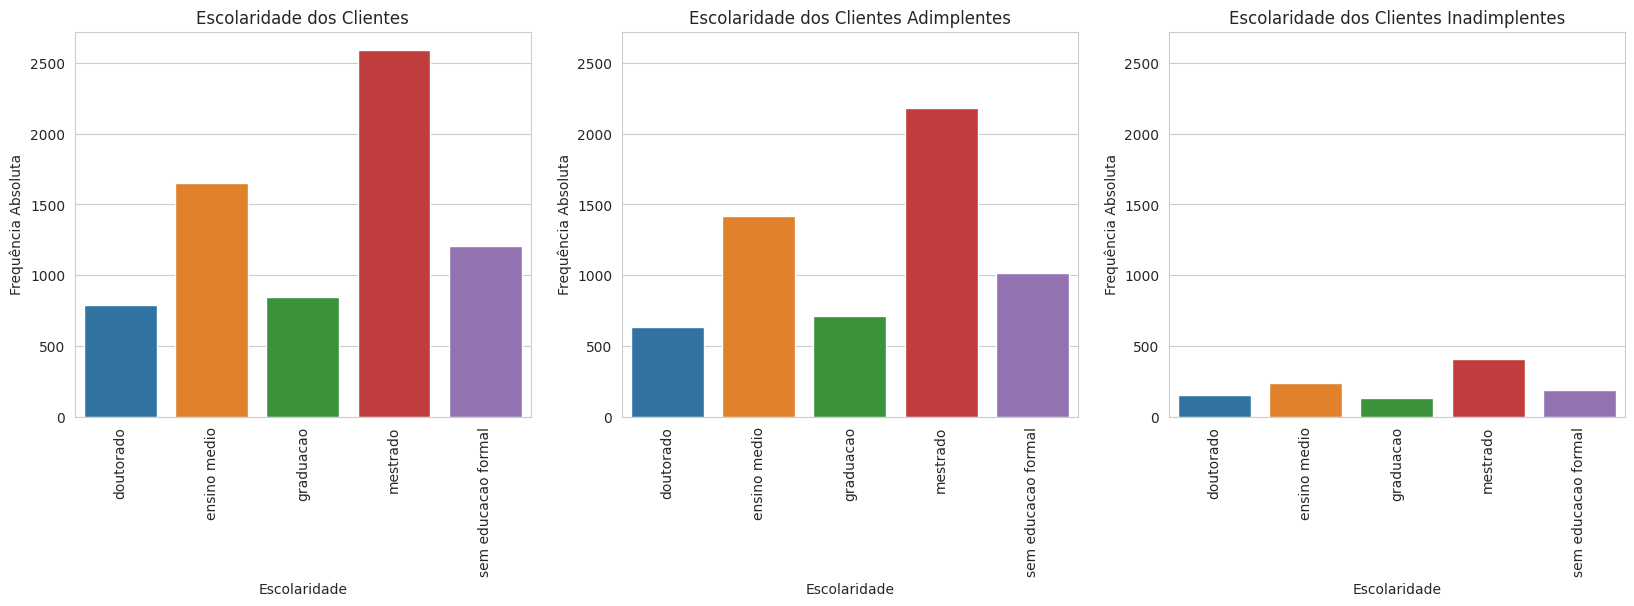

In [26]:
graficos_bar('escolaridade',['Escolaridade dos Clientes', 'Escolaridade dos Clientes Adimplentes', 'Escolaridade dos Clientes Inadimplentes'])

- #### Salário Anual

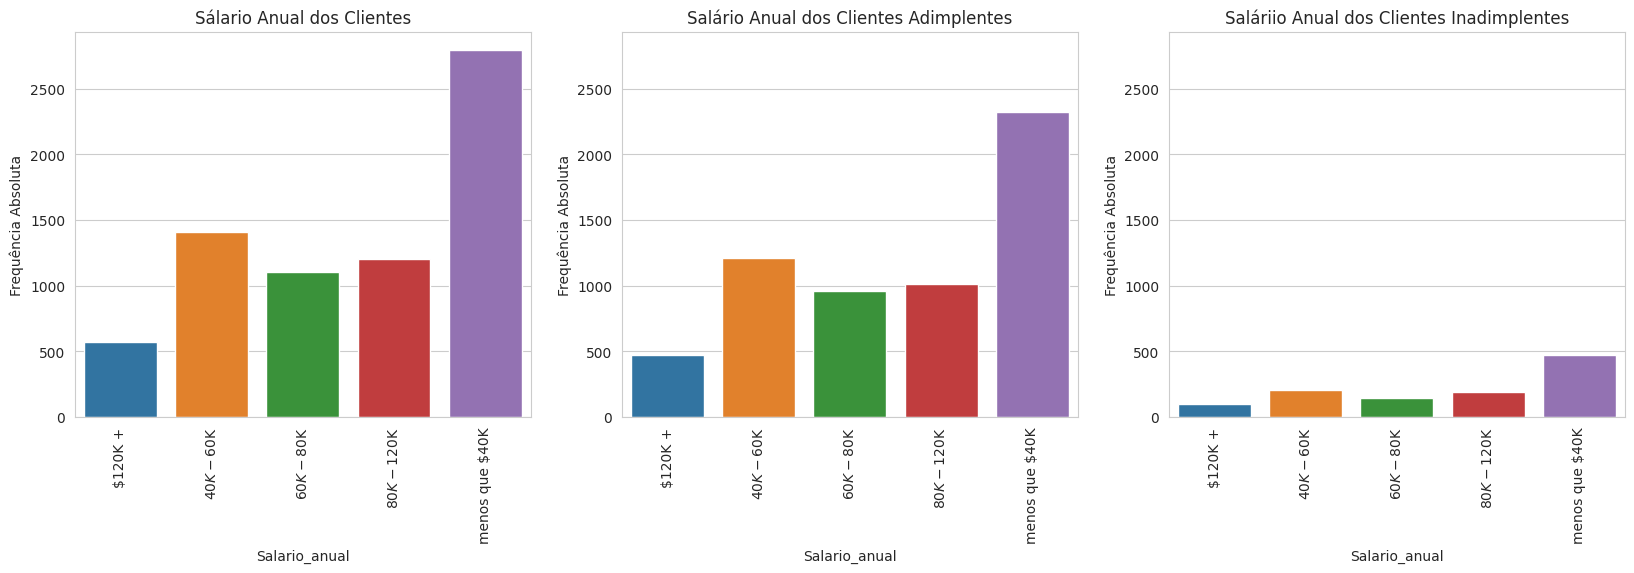

In [27]:
graficos_bar('salario_anual',['Sálario Anual dos Clientes', 'Salário Anual dos Clientes Adimplentes', 'Saláriio Anual dos Clientes Inadimplentes'])

- #### Tipo cartão

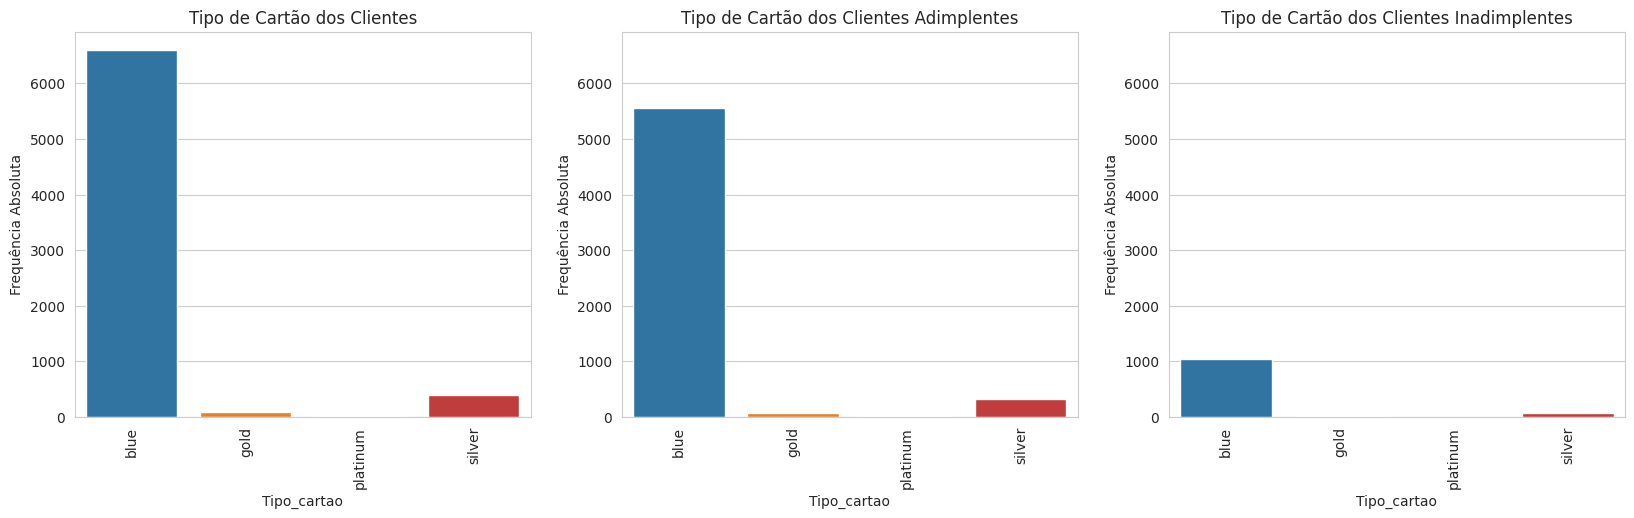

In [28]:
graficos_bar('tipo_cartao', ['Tipo de Cartão dos Clientes','Tipo de Cartão dos Clientes Adimplentes', 'Tipo de Cartão dos Clientes Inadimplentes'])

Observando ambos os gráficos, percebemos que as proporções se mantém, então não conseguimos retirar nenhuma informação significativa.

### Visualização de dados numéricos

Note que as variáveis `id` e `default` também são variáveis numéricas, porém não estamos interessado nelas para visualização gráfica, então podemos retirar essas colunas para facilitar a análise.

In [29]:
df.drop(['id','default'], axis=1).select_dtypes('number').head(n=5)

,idade,dependentes,meses_de_relacionamento,qtd_produtos,iteracoes_12m,meses_inativo_12m,limite_credito,valor_transacoes_12m,qtd_transacoes_12m
0,45,3,39,5,3,1,12691.51,1144.90,42
1,49,5,44,6,2,1,8256.96,1291.45,33
2,51,3,36,4,0,1,3418.56,1887.72,20
4,40,3,21,5,0,1,4716.22,816.08,28
5,44,2,36,3,2,1,4010.69,1088.07,24


In [30]:
def graficos_hist(coluna: str, titulos: list):
    max_y = 0
    figura, eixos = plt.subplots(1,3,figsize=(20,5),sharex=True)

    for eixo, dataframe in enumerate([df,df_adimplente,df_inadimplente]):

        grafico = sns.histplot(x=coluna, data=dataframe, stat='count', ax=eixos[eixo])
        grafico.set(title=titulos[eixo], xlabel=coluna.capitalize(), ylabel='Frequência Absoluta')

        _, max_y_grafico = grafico.get_ylim()
        max_y = max(max_y,max_y_grafico)
        grafico.set(ylim=(0, max_y))

    figura.show()

- #### Quantidade de transações nos últimos 12 meses

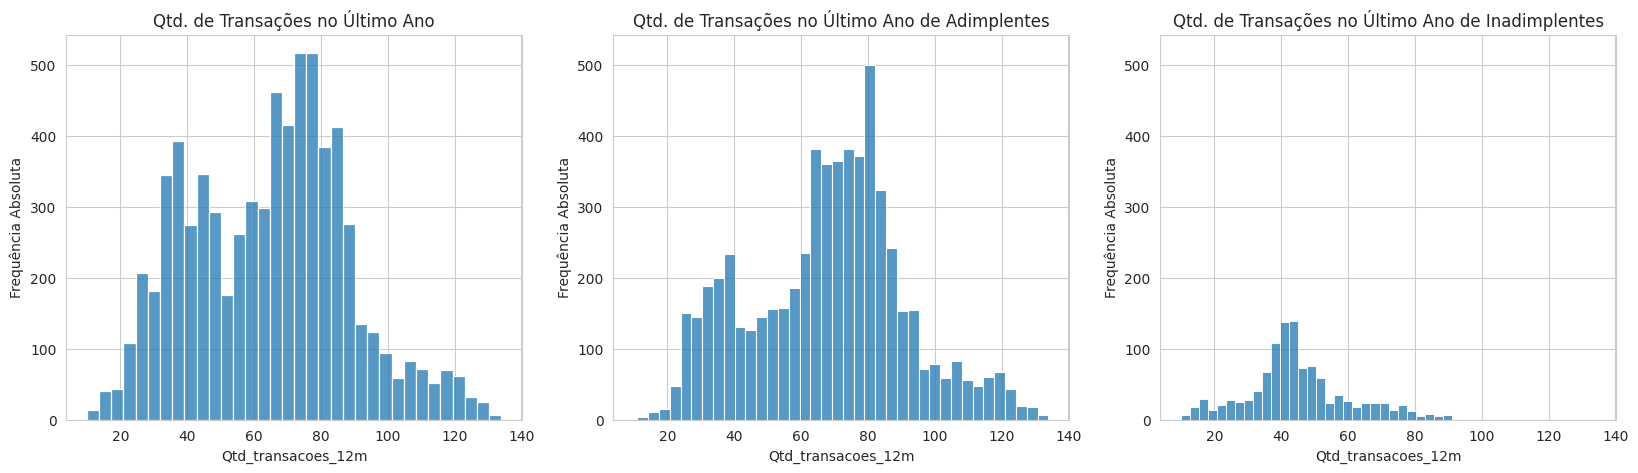

In [31]:
graficos_hist('qtd_transacoes_12m',['Qtd. de Transações no Último Ano', 'Qtd. de Transações no Último Ano de Adimplentes', 'Qtd. de Transações no Último Ano de Inadimplentes'])

- #### Valor das transações nos últimos 12 meses

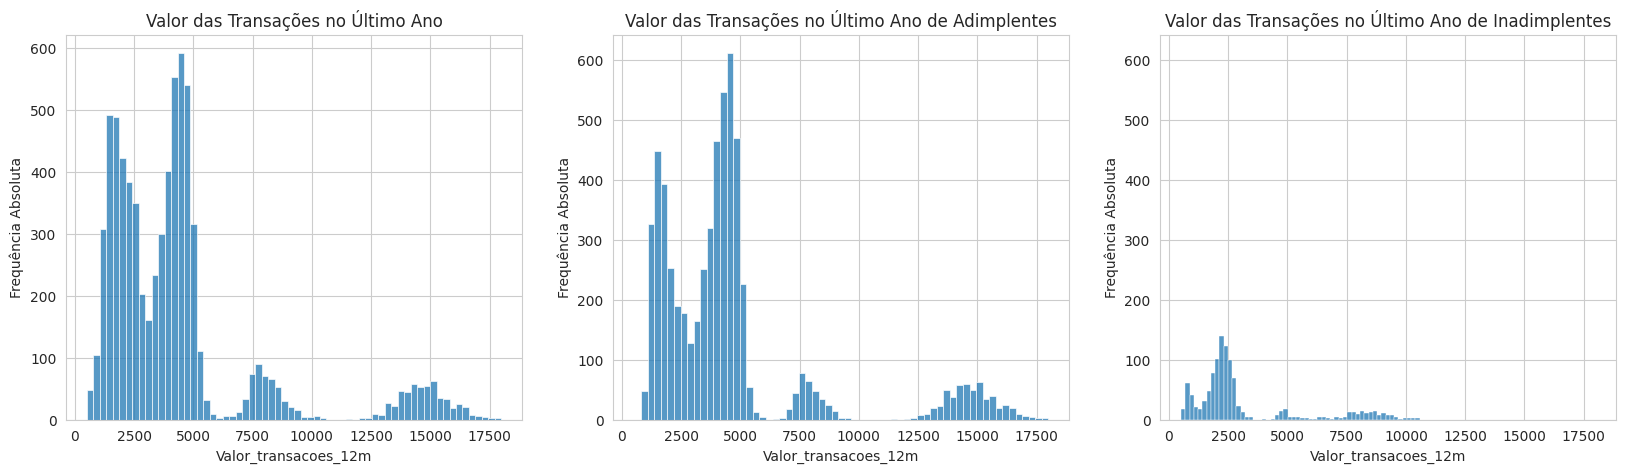

In [32]:
graficos_hist('valor_transacoes_12m',['Valor das Transações no Último Ano', 'Valor das Transações no Último Ano de Adimplentes', 'Valor das Transações no Último Ano de Inadimplentes'])

- #### Idade 

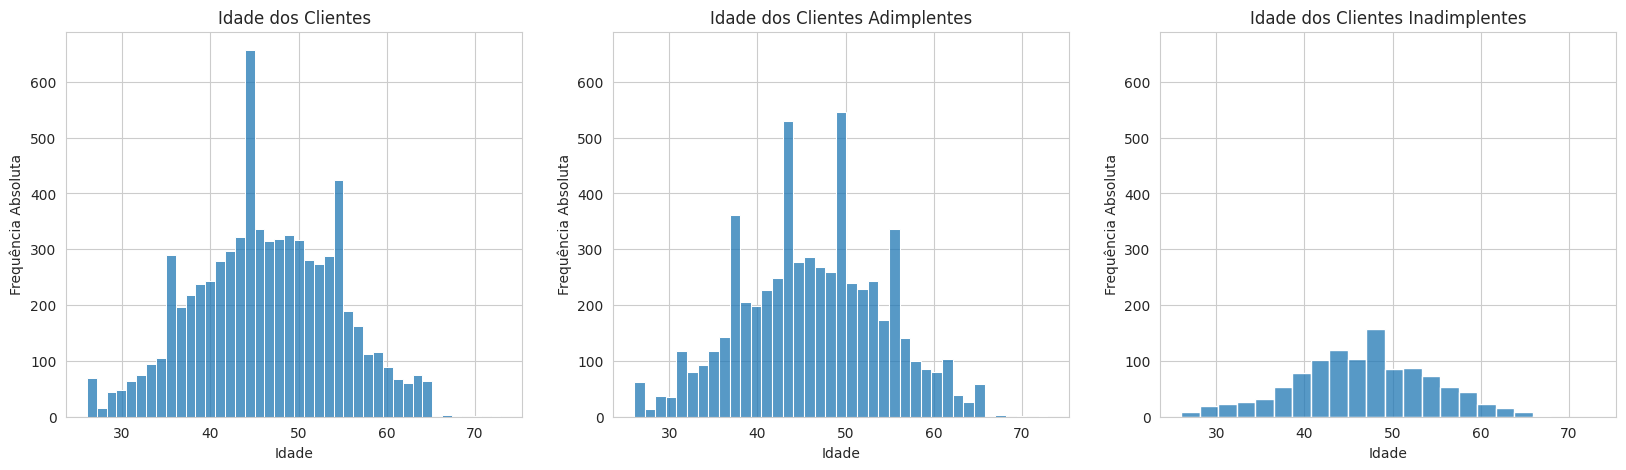

In [33]:
graficos_hist('idade',['Idade dos Clientes','Idade dos Clientes Adimplentes','Idade dos Clientes Inadimplentes'])

Analisando as variáveis `valor_transacoes_12m` onde os valores giram em torno de 2500 e `qtd_transacoes_12m` com uma quantidade de transação no intervalo de (40,60) há um indicio de maiores casos de inadimplência, nos indicando que pessoas que fazem transações em volta desse valor ou nesse intervalo de quantidade são mais propensas a não honrar com suas dívidas. 

De maneira contrária, através do histograma de idades vemos que existe alguns picos de idade onde os clientes são mais propensos a manter a regularidade das suas dívidas.

Apesar disso, nenhuma dessas observações nos dá uma análise conclusiva.

- #### Valor de Transações nos Últimos 12 Meses x Quantidade de Transações nos Últimos 12 Meses

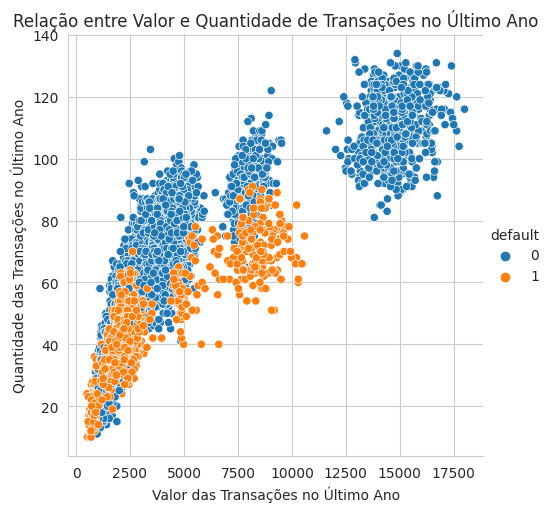

In [34]:
grafico = sns.relplot(x='valor_transacoes_12m',y='qtd_transacoes_12m', data=df, hue='default')
_ = grafico.set(
    title ='Relação entre Valor e Quantidade de Transações no Último Ano',
    xlabel='Valor das Transações no Último Ano',
    ylabel='Quantidade das Transações no Último Ano'
)

- #### Idade x Valor de Transações nos Últimos 12 Meses

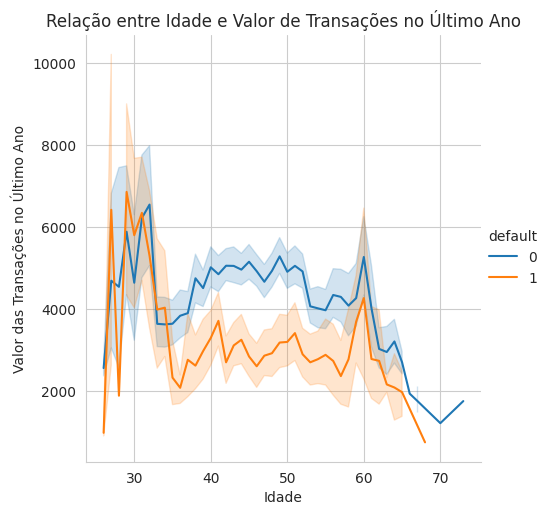

In [35]:
grafico = sns.relplot(x='idade',y='valor_transacoes_12m', data=df, kind='line', hue='default')
_ = grafico.set(
    title ='Relação entre Idade e Valor de Transações no Último Ano',
    xlabel='Idade',
    ylabel='Valor das Transações no Último Ano'
)

Fazendo uma relação entre idade e valor de transação já conseguimos observar que jovens com menos de 30 anos que fazem uma transação acima de 6000 tendem a se encontrar em situação de inadimplência.